<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw7/nn_hw7_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## _[NN HW7](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/05-nlp/02-fasttext/HomeWork.ipynb "NN HW7")_

Необходимо обучить регрессионную модель (предсказание популярности статьи на Хабре) - за [бейзлайн](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw7/nn_hw7_baseline.ipynb) возьмите tf-idf + линейная модель:

train - https://yadi.sk/d/hAhCuetI3JPouk

test - https://yadi.sk/d/mLMZZtN63JPouc

---

### [Baseline score](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw7/nn_hw7_baseline.ipynb): 
`MSE 1.3570`

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import gc
import warnings

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls -hAlF *.{csv,vec}

-rw------- 1 root root 2.5G May 13 04:57 ft_native_300_ru_wiki_lenta_lemmatize.vec
-rw------- 1 root root 107M May 13 04:57 test_content.csv
-rw------- 1 root root 1.8G May 13 04:58 train_content.csv


## 1. _Fasttext_

DeepPavlov’s [Pre-trained embeddings](http://docs.deeppavlov.ai/en/latest/intro/pretrained_vectors.html "Pre-trained embeddings").

In [4]:
!head -7 'ft_native_300_ru_wiki_lenta_lemmatize.vec' | cut -d' ' -f1-10 | sed '2,$ s/.*/&.../'

977837 300
, -0.19691 0.10625 0.22104 -0.022737 0.095721 0.033132 -0.11969 0.17552 0.026835...
. -0.22444 0.1004 0.20901 0.090732 -0.12241 0.036208 -0.017794 0.1247 -0.043839...
в -0.23989 -0.011713 0.15841 0.065439 -0.13313 0.056061 0.028891 0.16164 -0.068493...
и -0.10178 0.044071 0.16131 0.016189 -0.0013021 0.090599 -0.11217 0.10187 -0.057014...
на -0.21902 -0.036972 0.14425 0.09633 -0.15182 -0.077977 -0.028384 0.25189 0.097382...
год -0.22211 0.0023868 0.26481 0.016657 -0.16772 0.13828 0.0073285 0.058437 -0.1876...


In [0]:
def load_vectors(fasttext_vec_path):
    with open(fasttext_vec_path) as fasttext:
        count, length = ( int(x) for x in fasttext.readline().split() ) # header line
        embeddings = {}
        for line in tqdm_notebook(fasttext):
            value = line.split()
            word = value[0]
            coef = np.array(value[1:], dtype=np.float32)
            embeddings[word]=coef
        return count, length, embeddings

In [6]:
embedding_count, embedding_length, embedding_values = load_vectors('ft_native_300_ru_wiki_lenta_lemmatize.vec')

In [7]:
embedding_count, embedding_length, len(embedding_values), len(embedding_values['ф'])

(977837, 300, 977837, 300)

## 2. _Данные_

In [0]:
train_content = pd.read_csv('train_content.csv')
test_content = pd.read_csv('test_content.csv')

Отбросим пустые и совсем короткие тексты. Объединим заголовок и текст статьи. Одновременно сделаем перемешивание.

In [0]:
def select_content_favs(d, min_len=100, size=1.):
    w = (d['content'].notnull()) & (min_len < d['content'].str.len())
    i = np.argwhere(w).squeeze()
    i = i[np.random.choice(len(i), size=int(len(i) * size), replace=False)]
    return ((d['title'][i] + ' ' + d['content'][i]).values, d['favs_lognorm'][i].values)

In [10]:
X_train_text, y_train = select_content_favs(train_content)

del train_content, test_content

[ x.shape for x in (X_train_text, y_train) ]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


[(170211,), (170211,)]

In [11]:
[ s[:100] for s in X_train_text[:3] ]

['Скинь мне ссылку на планшет Я люблю читать.<br>\r\n<br>\r\nДа, начну именно так: «Я люблю читать». Мне п',
 'Может тебя тоже ищут? Сайт телепрограммы «Жди меня» Сейчас за ужином смотрел программу «Жди меня» по',
 'Надо держать планы в секрете? Инвесторы и их помощники наберебой развеивают страхи молодых стартапер']

## 3. _Модель_

In [12]:
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import layers as L
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [13]:
print(tf.__version__)
warnings.filterwarnings('ignore')

1.13.1


In [14]:
tokenizer = Tokenizer(num_words=2**20, lower=True)
tokenizer.fit_on_texts(X_train_text)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)

del X_train_text

print(f'{len(tokenizer.word_index)} unique tokens')

3124976 unique tokens


Распределение текстов по количеству слов:

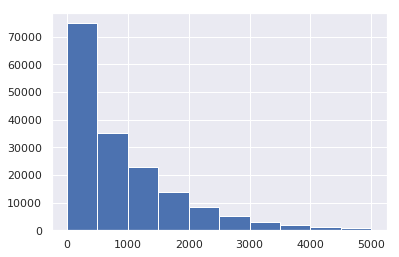

In [15]:
plt.hist([ len(x) for x in X_train_seq ], range=(0, 5000));

In [0]:
max_seq_length = 3000

X_train = pad_sequences(X_train_seq, maxlen=max_seq_length)

del X_train_seq

Для упрощения, слова из текста, для которых не найдётся соответствующего вектора эмбеддинга, будем заменять на вектор для произвольно выбранного слова:

In [17]:
replace_word = 'unk'

for i in range(tokenizer.num_words, len(tokenizer.index_word) + 1):
    if tokenizer.index_word[i] in embedding_values.keys():
        replace_word = tokenizer.index_word[i]
        break

replace_word

'pр'

In [18]:
embedding_matrix = np.zeros((tokenizer.num_words+1, embedding_length), dtype=np.float32)

for i, word in tqdm_notebook(tokenizer.index_word.items()):
    if i >= tokenizer.num_words:
        break

    try:
        embedding_vector = embedding_values[word]
    except KeyError:
        embedding_vector = embedding_values[replace_word] # TODO: using the most primitive logic to address missing words

    embedding_matrix[i] = embedding_vector

del embedding_values, tokenizer

gc.collect()

embedding_matrix.shape

(1048577, 300)

In [0]:
def make_model(embedding_matrix, input_length):

    input_layer = L.Input(shape=(input_length,))

    embedding_layer = L.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False)(input_layer)

    x = L.SpatialDropout1D(0.2)(embedding_layer)
    x = L.Bidirectional(L.CuDNNLSTM(64, return_sequences=True))(x)

    avg_pool1 = L.GlobalAveragePooling1D()(x)
    max_pool1 = L.GlobalMaxPooling1D()(x)

    x = L.concatenate([avg_pool1, max_pool1])

    output_layer = L.Dense(1, activation='linear')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr=1e-3, clipnorm=3, clipvalue=3))

    return model

In [0]:
def plot_history(hist):
    fig = plt.figure(figsize=(12, 7))
    ax = fig.gca()
    def plot_ax(ax, hist, title, train, val, loc='best'):
        last_epoch = len(hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[train])
        ax.plot(1 + np.arange(last_epoch), hist[val])
        
        ax.axvline(x=last_epoch, color='r', linestyle=':')
        bottom, top = ax.get_ylim()
        height = top - bottom
        ymid = bottom + height / 2
        ax.annotate(f'{last_epoch}', xy=(last_epoch, ymid))
        
        val_last = hist[val][last_epoch-1]
        ax.axhline(y=val_last, color='g', linestyle=':')
        left, right = ax.get_xlim()
        y2 = [top - height / 3, bottom + height / 3][bool(val_last < ymid)]
        ax.annotate(f'{val_last:.4f}', xy=(last_epoch, val_last), 
                    xytext=(last_epoch - (last_epoch - left) / 4, y2),
                    size = 14,
                    arrowprops=dict(arrowstyle='->',
                                    connectionstyle=f'arc3,rad={.3*[1, -1][bool(val_last < ymid)]:.1f}'))

        ax.set_title(title)
        ax.set_ylabel(train)
        ax.set_xlabel('epoch')
        ax.set_xticks(np.arange(0, last_epoch, 5))
        ax.legend(['train', 'val'], loc=loc)

    plot_ax(ax, hist, 'model loss', 'loss', 'val_loss')

In [21]:
model = make_model(embedding_matrix, max_seq_length)

history = model.fit(X_train, y_train, batch_size=256, epochs=25, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 136168 samples, validate on 34043 samples
Epoch 1/25
136168/136168 [==============================] - 390s 3ms/step - loss: 1.4194 - val_loss: 1.2137
Epoch 2/25
136168/136168 [==============================] - 388s 3ms/step - loss: 1.1857 - val_loss: 1.1223
Epoch 3/25
136168/136168 [==============================] - 387s 3ms/step - loss: 1.1163 - val_loss: 1.1408
Epoch 4/25
136168/136168 [==============================] - 387s 3ms/step - loss: 1.0732 - val_loss: 1.0674
Epoch 5/25
136168/136168 [==============================] - 388s 3ms/step - loss: 1.0403 - val_loss: 1.1219
Epoch 6/25
136168/136168 [==============================] - 388s 3ms/step - loss: 1.0110 - val_l

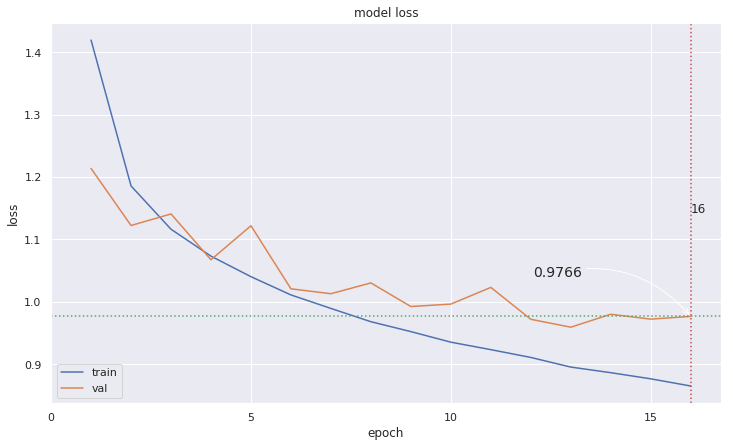

In [33]:
plot_history(history.history)

### Score:

In [34]:
print(f'MSE (on val): {history.history["val_loss"][-1]:.4f}')

MSE (on val): 0.9766
